# Try the Retinanet object detection algorithm

In [33]:
from pyclouds.imports import *
from pyclouds.helpers import wh2xy
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import pickle

## Prepare the data

We need to create a validation and training csv file that contains `filename, x1, y1, x2, y2, class`. So this is essentially one row per box. 

Here is an example of what such a file should look like.

In [40]:
!head ../processed_annotations/cloud_trn.csv

/local/S.Rasp/MPI_Aqua/Aqua_CorrectedReflectance20161224.png,,,,,
/local/S.Rasp/MPI_Aqua/Aqua_CorrectedReflectance20101228.png,108,25,1131,509,Cold pool
/local/S.Rasp/MPI_Aqua/Aqua_CorrectedReflectance20140106.png,463,419,1134,1131,Flower
/local/S.Rasp/MPI_Aqua/Aqua_CorrectedReflectance20140106.png,483,20,1128,379,Shallow
/local/S.Rasp/MPI_Aqua/Aqua_CorrectedReflectance20160205.png,,,,,
/local/S.Rasp/MPI_Aqua/Aqua_CorrectedReflectance20161215.png,,,,,
/local/S.Rasp/MPI_Aqua/Aqua_CorrectedReflectance20091208.png,16,689,1140,1130,Fishbone
/local/S.Rasp/MPI_Aqua/Aqua_CorrectedReflectance20091208.png,109,53,1121,643,Shallow
/local/S.Rasp/MPI_Aqua/Aqua_CorrectedReflectance20071215.png,209,775,1059,1121,Fishbone
/local/S.Rasp/MPI_Aqua/Aqua_CorrectedReflectance20071215.png,17,724,1108,1116,Cold pool


Let's load the annotation file from the basic-analysis notebook. This is for the full dataset without the not-logged-in users.

### Load and prepare the annotations CSV file.

In [4]:
#annos_prac = pd.read_csv('/local/S.Rasp/tmp/annos_prac.csv', index_col=0)
annos_full = pd.read_csv('/local/S.Rasp/tmp/annos_full.csv', index_col=0)

In [5]:
annos_full.head()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,...,subject_set,fn,datetime,x,y,width,height,tool_label,started_at,finished_at
0,129486316,raspstephan,1814911.0,80bdc4acf6d39d1ea32e,8073,Full dataset,13.11,2018-11-01 08:28:49 UTC,NaN,NaN,...,BCO_MAM_Aqua,Region1_MAM_Aqua/Aqua_CorrectedReflectance2007...,2018-11-01 08:28:49,190.188187,11.954011,957.533615,490.033599,Sugar,2018-11-01 08:28:37.425,2018-11-01 08:28:49.487
1,129486328,raspstephan,1814911.0,80bdc4acf6d39d1ea32e,8073,Full dataset,13.11,2018-11-01 08:29:02 UTC,NaN,NaN,...,R3_DJF_Aqua,Region3_DJF_Aqua/Aqua_CorrectedReflectance2015...,2018-11-01 08:29:02,31.104063,541.537842,1041.690615,843.354858,Sugar,2018-11-01 08:28:50.971,2018-11-01 08:29:01.859
2,129486340,raspstephan,1814911.0,80bdc4acf6d39d1ea32e,8073,Full dataset,13.11,2018-11-01 08:29:18 UTC,NaN,NaN,...,R3_SON_Terra,Region3_SON_Terra/Terra_CorrectedReflectance20...,2018-11-01 08:29:18,1008.944641,47.511284,1081.912537,965.749702,Flower,2018-11-01 08:29:03.018,2018-11-01 08:29:17.812
3,129486353,raspstephan,1814911.0,80bdc4acf6d39d1ea32e,8073,Full dataset,13.11,2018-11-01 08:29:32 UTC,NaN,NaN,...,BCO_DJF_Aqua,Region1_DJF_Aqua/Aqua_CorrectedReflectance2011...,2018-11-01 08:29:32,1172.625000,436.476868,916.030518,509.419983,Fish,2018-11-01 08:29:18.873,2018-11-01 08:29:32.091
4,129487308,raspstephan,1814911.0,80bdc4acf6d39d1ea32e,8073,Full dataset,13.11,2018-11-01 08:40:30 UTC,NaN,NaN,...,BCO_DJF_Aqua,Region1_DJF_Aqua/Aqua_CorrectedReflectance2011...,2018-11-01 08:40:30,1112.680786,325.314545,982.698120,726.035065,Flower,2018-11-01 08:40:20.517,2018-11-01 08:40:30.377


In [6]:
len(annos_full)

49132

In [7]:
# This is where the images are stored
SSDDIR = '/local/S.Rasp/cloud-classification/'

In [8]:
# Only extract the relevant quantities
annos_ret = annos_full[['fn', 'x', 'y', 'width', 'height', 'tool_label']]

In [9]:
annos_ret.head()

,fn,x,y,width,height,tool_label
0,Region1_MAM_Aqua/Aqua_CorrectedReflectance2007...,190.188187,11.954011,957.533615,490.033599,Sugar
1,Region3_DJF_Aqua/Aqua_CorrectedReflectance2015...,31.104063,541.537842,1041.690615,843.354858,Sugar
2,Region3_SON_Terra/Terra_CorrectedReflectance20...,1008.944641,47.511284,1081.912537,965.749702,Flower
3,Region1_DJF_Aqua/Aqua_CorrectedReflectance2011...,1172.625000,436.476868,916.030518,509.419983,Fish
4,Region1_DJF_Aqua/Aqua_CorrectedReflectance2011...,1112.680786,325.314545,982.698120,726.035065,Flower


#### Convert xywh to x1y1x2y2

In [10]:
annos_ret['width'] = annos_full.apply(lambda r: wh2xy(r.x, r.y, r.width, r.height)[2], axis=1)
annos_ret['height'] = annos_full.apply(lambda r: wh2xy(r.x, r.y, r.width, r.height)[3], axis=1)

/home/s/S.Rasp/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/s/S.Rasp/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Prepend file path to filenames

In [11]:
annos_ret['fn'] = annos_ret['fn'].apply(lambda fn: SSDDIR + fn)

/home/s/S.Rasp/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Fix obviously unrealistic values

Some of the coordinates are either less than 0 or larger than the max image size. We will clip them to their max/min allowed values.

In [12]:
annos_ret.describe()

,x,y,width,height
count,43375.000000,43375.000000,43375.000000,43375.000000
mean,596.894456,397.153757,1527.317734,1014.643589
std,535.782875,340.494136,551.447971,336.465426
min,-625.336113,-401.602203,14.969124,0.257120
25%,50.362865,57.169327,1058.579529,745.107605
50%,503.460297,344.350464,1625.667969,1057.181396
75%,1043.826843,679.340698,2077.488037,1352.490295
max,2184.584961,1312.114868,3022.807861,1740.566650


First we will remove the entries where the lower left coordinates exceed the upper right coordinate of the image.

In [13]:
annos_ret = annos_ret[annos_ret.x.apply(lambda x: np.isnan(x) or x < 2099)]
annos_ret = annos_ret[annos_ret.y.apply(lambda x: np.isnan(x) or x < 2099)]

In [53]:
annos_ret.iloc[:7]

,fn,x,y,width,height,tool_label
0,/local/S.Rasp/cloud-classification/Region1_MAM...,190.188187,11.954011,1147.721802,501.987610,Sugar
1,/local/S.Rasp/cloud-classification/Region3_DJF...,31.104063,541.537842,1072.794678,1384.892700,Sugar
2,/local/S.Rasp/cloud-classification/Region3_SON...,1008.944641,47.511284,2090.857178,1013.260986,Flower
3,/local/S.Rasp/cloud-classification/Region1_DJF...,1172.625000,436.476868,2088.655518,945.896851,Fish
4,/local/S.Rasp/cloud-classification/Region1_DJF...,1112.680786,325.314545,2095.378906,1051.349609,Flower
5,/local/S.Rasp/cloud-classification/Region3_DJF...,NaN,NaN,NaN,NaN,NaN
6,/local/S.Rasp/cloud-classification/Region1_MAM...,902.583801,22.788500,1576.635742,651.126648,Gravel


Then we will clip the values. We will also make sure that the upper right coordinates are at least 1. Zero would lead to a non-existing box.

In [14]:
# Fix wrong values
annos_ret['x'] = np.maximum(annos_ret['x'], 0)
annos_ret['y'] = np.maximum(annos_ret['y'], 0)
annos_ret['width'] = np.maximum(np.minimum(annos_ret['width'], 2100), 1)
annos_ret['height'] = np.maximum(np.minimum(annos_ret['height'], 1400), 1)

Finally, we will round the values to integers.

In [15]:
for c in ['x', 'y', 'width', 'height']:
    annos_ret[c] = annos_ret[c].round()

In [16]:
annos_ret.iloc[:7]

,fn,x,y,width,height,tool_label
0,/local/S.Rasp/cloud-classification/Region1_MAM...,190.0,12.0,1148.0,502.0,Sugar
1,/local/S.Rasp/cloud-classification/Region3_DJF...,31.0,542.0,1073.0,1385.0,Sugar
2,/local/S.Rasp/cloud-classification/Region3_SON...,1009.0,48.0,2091.0,1013.0,Flower
3,/local/S.Rasp/cloud-classification/Region1_DJF...,1173.0,436.0,2089.0,946.0,Fish
4,/local/S.Rasp/cloud-classification/Region1_DJF...,1113.0,325.0,2095.0,1051.0,Flower
5,/local/S.Rasp/cloud-classification/Region3_DJF...,NaN,NaN,NaN,NaN,NaN
6,/local/S.Rasp/cloud-classification/Region1_MAM...,903.0,23.0,1577.0,651.0,Gravel


#### Some annoying technical stuff to save the values as integers

In [17]:
# First, replace all NaNs with empty strings
annos_ret.replace(np.nan, '', inplace=True)

In [18]:
annos_ret.iloc[:7]

,fn,x,y,width,height,tool_label
0,/local/S.Rasp/cloud-classification/Region1_MAM...,190,12,1148,502,Sugar
1,/local/S.Rasp/cloud-classification/Region3_DJF...,31,542,1073,1385,Sugar
2,/local/S.Rasp/cloud-classification/Region3_SON...,1009,48,2091,1013,Flower
3,/local/S.Rasp/cloud-classification/Region1_DJF...,1173,436,2089,946,Fish
4,/local/S.Rasp/cloud-classification/Region1_DJF...,1113,325,2095,1051,Flower
5,/local/S.Rasp/cloud-classification/Region3_DJF...,,,,,
6,/local/S.Rasp/cloud-classification/Region1_MAM...,903,23,1577,651,Gravel


Then cast all values as strings.

In [19]:
annos_ret[['x', 'y', 'width', 'height']] = annos_ret[['x', 'y', 'width', 'height']].astype(str)

In [20]:
annos_ret.head()

,fn,x,y,width,height,tool_label
0,/local/S.Rasp/cloud-classification/Region1_MAM...,190.0,12.0,1148.0,502.0,Sugar
1,/local/S.Rasp/cloud-classification/Region3_DJF...,31.0,542.0,1073.0,1385.0,Sugar
2,/local/S.Rasp/cloud-classification/Region3_SON...,1009.0,48.0,2091.0,1013.0,Flower
3,/local/S.Rasp/cloud-classification/Region1_DJF...,1173.0,436.0,2089.0,946.0,Fish
4,/local/S.Rasp/cloud-classification/Region1_DJF...,1113.0,325.0,2095.0,1051.0,Flower


Unfortunately, we need to remove the .0 at the end using some ugly trick.

In [21]:
for c in ['x', 'y', 'width', 'height']:
    annos_ret[c] = annos_ret[c].apply(lambda s: s[:-2] if len(s)>0 else s)

In [22]:
annos_ret.head()

,fn,x,y,width,height,tool_label
0,/local/S.Rasp/cloud-classification/Region1_MAM...,190,12,1148,502,Sugar
1,/local/S.Rasp/cloud-classification/Region3_DJF...,31,542,1073,1385,Sugar
2,/local/S.Rasp/cloud-classification/Region3_SON...,1009,48,2091,1013,Flower
3,/local/S.Rasp/cloud-classification/Region1_DJF...,1173,436,2089,946,Fish
4,/local/S.Rasp/cloud-classification/Region1_DJF...,1113,325,2095,1051,Flower


In [23]:
len(annos_ret)

49130

Now we have the rows in the format we need.

### Split into train and valid

Next we need to get a reproducible train valid split. The order of images is already random in the way they were presented on Zooniverse. So we will just make a hard cut. Later we can separate different regions.

In [24]:
# Get a list of all subjects
all_subj = list(set(annos_full.fn))

In [31]:
all_subj[:5]

['Region3_SON_Aqua/Aqua_CorrectedReflectance20151109_-135--114_-15--1.jpeg',
 'Region1_DJF_Terra/Terra_CorrectedReflectance20111214_-61--40_10-24.jpeg',
 'Region1_DJF_Terra/Terra_CorrectedReflectance20171218_-61--40_10-24.jpeg',
 'Region1_MAM_Aqua/Aqua_CorrectedReflectance20160420_-61--40_10-24.jpeg',
 'Region1_MAM_Terra/Terra_CorrectedReflectance20120311_-61--40_10-24.jpeg']

Unfortunately there are some corrupted image files (probably just on my end). As you can see below, the number is not significant. So we will just throw them out.

In [69]:
# # Test image files
# bad_files = []
# for s in tqdm(all_subj):
#     try:
#         img = np.asarray(Image.open(SSDDIR + s).convert('RGB'))
#     except:
#         bad_files.append(s)

In [26]:
bad_files = ['Region3_SON_Aqua/Aqua_CorrectedReflectance20151003_-135--114_-15--1.jpeg',
 'Region3_SON_Aqua/Aqua_CorrectedReflectance20091028_-135--114_-15--1.jpeg',
 'Region1_MAM_Terra/Terra_CorrectedReflectance20170302_-61--40_10-24.jpeg',
 'Region1_MAM_Terra/Terra_CorrectedReflectance20070512_-61--40_10-24.jpeg',
 'Region1_DJF_Aqua/Aqua_CorrectedReflectance20170221_-61--40_10-24.jpeg',
 'Region2_DJF_Terra/Terra_CorrectedReflectance20071208_159-180_8-22.jpeg',
 'Region3_SON_Aqua/Aqua_CorrectedReflectance20161022_-135--114_-15--1.jpeg',
 'Region3_SON_Terra/Terra_CorrectedReflectance20091021_-135--114_-15--1.jpeg',
 'Region1_DJF_Aqua/Aqua_CorrectedReflectance20130116_-61--40_10-24.jpeg',
 'Region2_DJF_Aqua/Aqua_CorrectedReflectance20101201_159-180_8-22.jpeg',
 'Region1_DJF_Terra/Terra_CorrectedReflectance20070227_-61--40_10-24.jpeg',
 'Region1_MAM_Terra/Terra_CorrectedReflectance20130308_-61--40_10-24.jpeg',
 'Region1_DJF_Aqua/Aqua_CorrectedReflectance20110211_-61--40_10-24.jpeg',
 'Region3_DJF_Terra/Terra_CorrectedReflectance20140123_-135--114_-15--1.jpeg',
 'Region1_DJF_Aqua/Aqua_CorrectedReflectance20071217_-61--40_10-24.jpeg',
 'Region2_DJF_Terra/Terra_CorrectedReflectance20170224_159-180_8-22.jpeg',
 'Region3_DJF_Terra/Terra_CorrectedReflectance20080101_-135--114_-15--1.jpeg',
 'Region3_DJF_Aqua/Aqua_CorrectedReflectance20071218_-135--114_-15--1.jpeg',
 'Region3_DJF_Aqua/Aqua_CorrectedReflectance20071201_-135--114_-15--1.jpeg',
 'Region2_DJF_Terra/Terra_CorrectedReflectance20171213_159-180_8-22.jpeg',
 'Region3_DJF_Aqua/Aqua_CorrectedReflectance20090111_-135--114_-15--1.jpeg',
 'Region1_DJF_Aqua/Aqua_CorrectedReflectance20071207_-61--40_10-24.jpeg',
 'Region3_DJF_Terra/Terra_CorrectedReflectance20070103_-135--114_-15--1.jpeg',
 'Region2_DJF_Terra/Terra_CorrectedReflectance20161220_159-180_8-22.jpeg']

In [27]:
len(all_subj)

9744

In [28]:
all_subj = [s for s in all_subj if s not in bad_files]

In [29]:
len(all_subj)

9720

In total we have around 10k images. We will just do an 80/20% split.

In [32]:
train_subj = all_subj[:8000]
valid_subj = all_subj[8000:]

In [35]:
with open('/local/S.Rasp/tmp/subj_fns.pkl', 'wb') as f:
    pickle.dump((all_subj, train_subj, valid_subj), f)

Now we need to pick all corresponding annotations.

In [36]:
annos_ret.fn.iloc[0][35:]

'Region1_MAM_Aqua/Aqua_CorrectedReflectance20070331_-61--40_10-24.jpeg'

In [37]:
annos_ret_train = annos_ret[annos_ret.fn.apply(lambda fn: fn[35:] in train_subj)]

In [38]:
annos_ret_valid = annos_ret[annos_ret.fn.apply(lambda fn: fn[35:] in valid_subj)]

In [39]:
len(annos_ret), len(annos_ret_train), len(annos_ret_valid)

(49130, 40460, 8556)

In [40]:
annos_ret_train.to_csv('/local/S.Rasp/tmp/annos_ret_train.csv', header=False, index=False)

In [41]:
annos_ret_valid.to_csv('/local/S.Rasp/tmp/annos_ret_valid.csv', header=False, index=False)

In [42]:
!head /local/S.Rasp/tmp/annos_ret_train.csv

/local/S.Rasp/cloud-classification/Region1_MAM_Aqua/Aqua_CorrectedReflectance20070331_-61--40_10-24.jpeg,190,12,1148,502,Sugar
/local/S.Rasp/cloud-classification/Region3_DJF_Aqua/Aqua_CorrectedReflectance20150205_-135--114_-15--1.jpeg,31,542,1073,1385,Sugar
/local/S.Rasp/cloud-classification/Region3_SON_Terra/Terra_CorrectedReflectance20121001_-135--114_-15--1.jpeg,1009,48,2091,1013,Flower
/local/S.Rasp/cloud-classification/Region1_DJF_Aqua/Aqua_CorrectedReflectance20110118_-61--40_10-24.jpeg,1173,436,2089,946,Fish
/local/S.Rasp/cloud-classification/Region1_DJF_Aqua/Aqua_CorrectedReflectance20110216_-61--40_10-24.jpeg,1113,325,2095,1051,Flower
/local/S.Rasp/cloud-classification/Region3_DJF_Aqua/Aqua_CorrectedReflectance20081226_-135--114_-15--1.jpeg,,,,,
/local/S.Rasp/cloud-classification/Region1_MAM_Aqua/Aqua_CorrectedReflectance20070507_-61--40_10-24.jpeg,903,23,1577,651,Gravel
/local/S.Rasp/cloud-classification/Region1_MAM_Terra/Terra_CorrectedReflectance20120324_-61--40_10-24.jpeg,

### Class csv

Finally, we also need a csv file with all the classes.

In [43]:
clas_df = pd.DataFrame(data={'name': ['Flower', 'Fish', 'Gravel', 'Sugar'], 'id': range(4)})

In [44]:
clas_df

,name,id
0,Flower,0
1,Fish,1
2,Gravel,2
3,Sugar,3


In [45]:
clas_df.to_csv('/local/S.Rasp/tmp/clas_ret.csv', header=False, index=False)

## Try running retinanet

Here is the code I am using to run the keras-retinanet version. NOTE: After initial attempts I increased the size of the anchors.

```shell
keras_retinanet/bin/train.py \
--epochs 20 \
--batch-size 4 \
--steps 2000 \   # This only adds up to 8k annotations out of the 40k in the train set (but they are random)
--image-max-side 700 \   # Maybe we can increase that later but it probably doesn't make much of a difference
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/ \
csv /local/S.Rasp/tmp/annos_ret_train.csv /local/S.Rasp/tmp/clas_ret.csv \
--val-annotations /local/S.Rasp/tmp/annos_ret_valid.csv
```

In [165]:
%cd ../../keras-retinanet/

[Errno 2] No such file or directory: '../../keras-retinanet/'
/home/s/S.Rasp/repositories/keras-retinanet


In [166]:
!ls

build		 ISSUE_TEMPLATE.md  processed_annotations  retina_val.csv
CONTRIBUTORS.md  keras_retinanet    README.md		   setup.cfg
examples	 LICENSE	    retina_cls.csv	   setup.py
images		 logs		    retina_trn.csv	   tests


In [167]:
!keras_retinanet/bin/train.py --epochs 1 --steps 2000 --image-max-side 1050 \
csv /local/S.Rasp/tmp/annos_ret_train.csv /local/S.Rasp/tmp/clas_ret.csv \
--val-annotations /local/S.Rasp/tmp/annos_ret_valid.csv

Using TensorFlow backend.
/home/s/S.Rasp/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
2019-01-21 16:00:23.986326: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F FMA
2019-01-21 16:00:24.178649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 0 with properties: 
name: GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 0000:b3:00.0
totalMemory: 7.93GiB freeMemory: 5.62GiB
2019-01-21 16:00:24.178682: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1435] Adding visible gpu devices: 0
2019-01-21 16:00:24.434898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:923] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-01-21 16:00:24.434934: I tensorflow/core/common_ru

/home/s/S.Rasp/miniconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
Epoch 1/50
keras_retinanet/bin/../../keras_retinanet/preprocessing/generator.py:148: UserWarning: Image with id 4133 (shape (1400, 2100, 3)) contains the following invalid boxes: [array([1820.,  937., 2098., 1423.,    0.]), array([1580.,    6., 2160.,  584.,    0.]), array([-3.000e+01, -2.400e+01,  1.586e+03,  8.410e+02,  1.000e+00])].
  [annotations[invalid_index, :] for invalid_index in invalid_indices]
keras_retinanet/bin/../../keras_retinanet/preprocessing/generator.py:148: UserWarning: Image with id 2196 (shape (1400, 2100, 3)) contains the following invalid boxes: [array([ 280.,  867., 1970., 1409.,    0.])].
  [annotations[invalid_index, :] for invalid_index in invalid_indices]
keras_retinanet/bin/../../keras_retinanet/preprocessing/generator.py:148: UserW

In [ ]:
!keras_retinanet/bin/train.py --epochs 20 --batch-size 4 --steps 2000 --image-max-side 700 \
--snapshot-path /project/meteo/work/S.Rasp/cloud-classification/retinanet-snapshots/ csv /local/S.Rasp/tmp/annos_ret_train.csv /local/S.Rasp/tmp/clas_ret.csv \
--val-annotations /local/S.Rasp/tmp/annos_ret_valid.csv

## Test trained model

In [1]:
# import keras_retinanet
import keras
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [2]:
clas_df

NameError: name 'clas_df' is not defined

In [3]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = '/home/s/S.Rasp/repositories/keras-retinanet/snapshots/resnet50_csv_07.h5'#os.path.join('/local/S.Rasp/tmp/', 'resnet50_csv_25.h5')

# load retinanet model
#model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
model = models.load_model(model_path, backbone_name='resnet50', convert=True)

#print(model.summary())

# load label to names mapping for visualization purposes

#labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}
labels_to_names = {i: l for i, l in enumerate(['Flower', 'Fish', 'Gravel', 'Sugar'])}

In [21]:
def draw_caption(image, box, caption):
    """ Draws a caption above the box in an image.
    # Arguments
        image   : The image to draw on.
        box     : A list of 4 elements (x1, y1, x2, y2).
        caption : String containing the text to draw.
    """
    b = np.array(box).astype(int)
    #cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 5, (0, 255, 0), 2)

In [5]:
import pandas as pd

In [9]:
val_df = pd.read_csv('/local/S.Rasp/tmp/annos_ret_valid.csv', header=None)

In [11]:
val_df.head()

,0,1,2,3,4,5
0,/local/S.Rasp/cloud-classification/Region3_SON...,1009.0,48.0,2091.0,1013.0,Flower
1,/local/S.Rasp/cloud-classification/Region3_SON...,24.0,14.0,855.0,1378.0,Sugar
2,/local/S.Rasp/cloud-classification/Region3_SON...,1281.0,16.0,2074.0,586.0,Flower
3,/local/S.Rasp/cloud-classification/Region3_DJF...,111.0,57.0,2089.0,1384.0,Sugar
4,/local/S.Rasp/cloud-classification/Region3_DJF...,1252.0,10.0,2096.0,1400.0,Flower


In [83]:
ann

{60811: 'BCO_DJF_Aqua',
 60812: 'BCO_DJF_Terra',
 60813: 'BCO_MAM_Aqua',
 60814: 'BCO_MAM_Terra',
 60815: 'R2_DJF_Aqua',
 60816: 'R2_DJF_Terra',
 60817: 'R3_DJF_Aqua',
 60818: 'R3_DJF_Terra',
 60819: 'R3_SON_Aqua',
 60835: 'R3_SON_Terra'}

In [30]:
l2c = {'Sugar': [241, 244, 66], 'Flower': [244, 65, 65], 'Fish': [65, 241, 244], 'Gravel':[73, 244, 65]}

In [188]:
fn = val_df[0][1211]

processing time:  0.09568262100219727


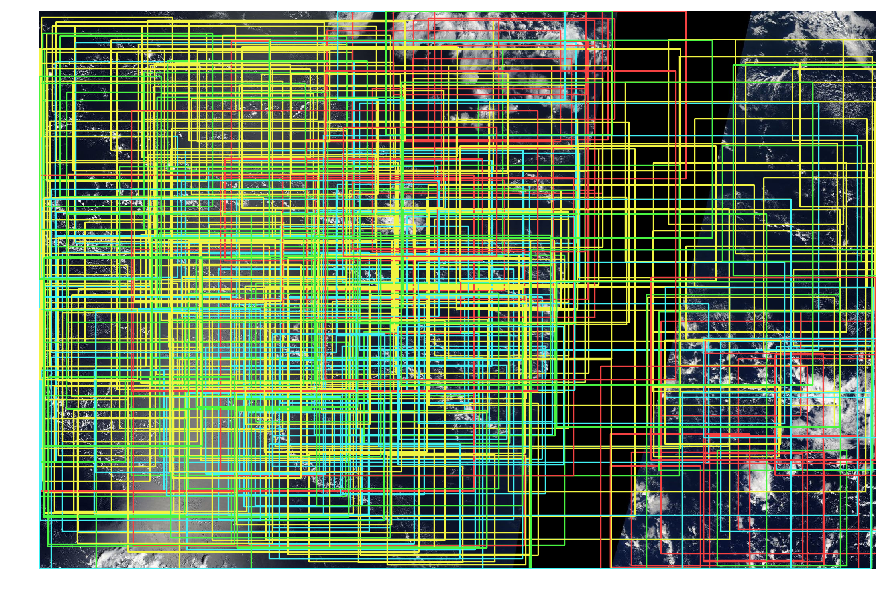

In [221]:
# load image
image = read_image_bgr(fn)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score <= 0.0:
        break
        
    color = l2c[labels_to_names[label]]  #label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    #draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

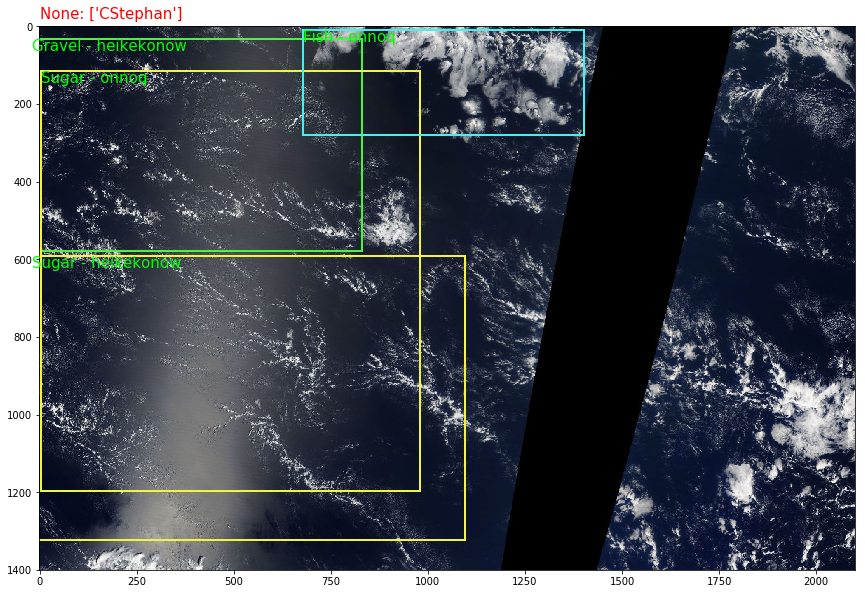

In [190]:
plot_img_with_annos(fn)

In [84]:
subj_fn = '../zooniverse_raw/sugar-flower-fish-or-gravel-subjects_18_11_05.csv'

In [86]:
from pyclouds.zooniverse import *

In [87]:
subj = load_classifications(subj_fn)

In [93]:
subj.head()

,subject_id,project_id,workflow_id,subject_set_id,metadata,locations,classifications_count,retired_at,retirement_reason,created_at,updated_at
0,26976345,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:28 UTC,2018-10-24 16:42:28 UTC
1,26976346,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:29 UTC,2018-10-24 16:42:29 UTC
2,26976347,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:31 UTC,2018-10-24 16:42:31 UTC
3,26976348,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:32 UTC,2018-10-24 16:42:32 UTC
4,26976349,7699,NaN,60713,{'fn': '/project/meteo/work/S.Rasp/cloud-class...,"{""0"":""https://panoptes-uploads.zooniverse.org/...",0,NaN,NaN,2018-10-24 16:42:33 UTC,2018-10-24 16:42:33 UTC


In [97]:
fn2id = {}
for i, r in subj.iterrows():
    try:
        fn2id[SSDDIR + r.metadata['fn'][48:]] = r.subject_id
    except:
        print(r.metadata)

{'Filename': 'Aqua_CorrectedReflectance20071227_-61--40_10-24.jpeg'}
{'Filename': 'Aqua_CorrectedReflectance20080103_-61--40_10-24.jpeg'}
{'Filename': 'Aqua_CorrectedReflectance20080120_-61--40_10-24.jpeg'}
{'Filename': 'Aqua_CorrectedReflectance20090112_-61--40_10-24.jpeg'}
{'Filename': 'Aqua_CorrectedReflectance20090122_-61--40_10-24.jpeg'}
{'Filename': 'Aqua_CorrectedReflectance20090130_-61--40_10-24.jpeg'}
{'Filename': 'Aqua_CorrectedReflectance20090202_-61--40_10-24.jpeg'}
{'Filename': 'Aqua_CorrectedReflectance20090216_-61--40_10-24.jpeg'}
{'Filename': 'Aqua_CorrectedReflectance20100107_-61--40_10-24.jpeg'}
{'Filename': 'Aqua_CorrectedReflectance20141230_-61--40_10-24.jpeg'}
{'Filename': 'Aqua_CorrectedReflectance20141231_-61--40_10-24.jpeg'}
{'Filename': 'Aqua_CorrectedReflectance20151205_-61--40_10-24.jpeg'}
{'Filename': 'Aqua_CorrectedReflectance20090427_-61--40_10-24.jpeg'}
{'Filename': 'Aqua_CorrectedReflectance20090918_-135--114_-15--1.jpeg'}
{'Filename': 'Aqua_CorrectedRef

In [99]:
fn2id[val_df[0][3]]

27146271

In [128]:
def plot_img_with_annos(fn):
    fig, ax = plt.subplots(figsize=(15, 10))
    #fn = str(SSDDIR + subj[subj.subject_id == subj_id].iloc[0]['fn'])
    img = Image.open(fn)
    ax.imshow(img)
    ans = annos_full[annos_full.subject_ids == fn2id[fn]]
    nones = []
    for i, a in ans.iterrows():
        if np.isfinite(a['x']):
            rect = patches.Rectangle((a['x'],a['y']), a['width'], a['height'], facecolor='none', 
                                     edgecolor=np.array(l2c[a['tool_label']])/255, lw=2)
            ax.add_patch(rect)
            ax.text(a['x'], a['y'], a['tool_label'] + ' - ' + a['user_name'], color=(0,1,0), fontsize=15, va='top')
        else:
            nones.append(a['user_name'])
    if len(nones) > 0:
        ax.text(0, -50, 'None: ' + str(nones), color='red', fontsize=15, va='top')

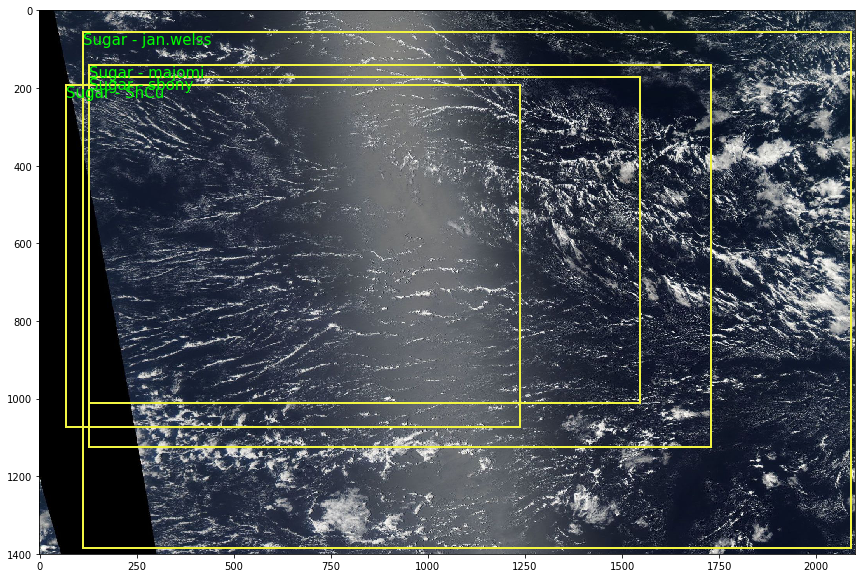

In [129]:
plot_img_with_annos(val_df[0][3])

## Check anchors

In [217]:
# Defaults in keras.retinanet
sizes   = [64, 128, 256, 512, 1024] #[32, 64, 128, 256, 512]
strides = [8, 16, 32, 64, 128]
ratios  = np.array([0.5, 1, 2], keras.backend.floatx())
scales  = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)], keras.backend.floatx())

In [192]:
ratios

(array([0.5, 1. , 2. ], dtype=float32),)

In [194]:
from keras_retinanet.utils import anchors

In [202]:
# (x1, y1, x2, y2)
anchs =anchors.generate_anchors(512, ratios, scales)

In [199]:
??wh2xy

In [200]:
#EXPORT
def xy2wh(x1, y1, x2, y2):
    return x1, x2, x2-x1, y2-y1

In [211]:
import seaborn as sns

In [212]:
cc = sns.color_palette("Paired", len(sizes))

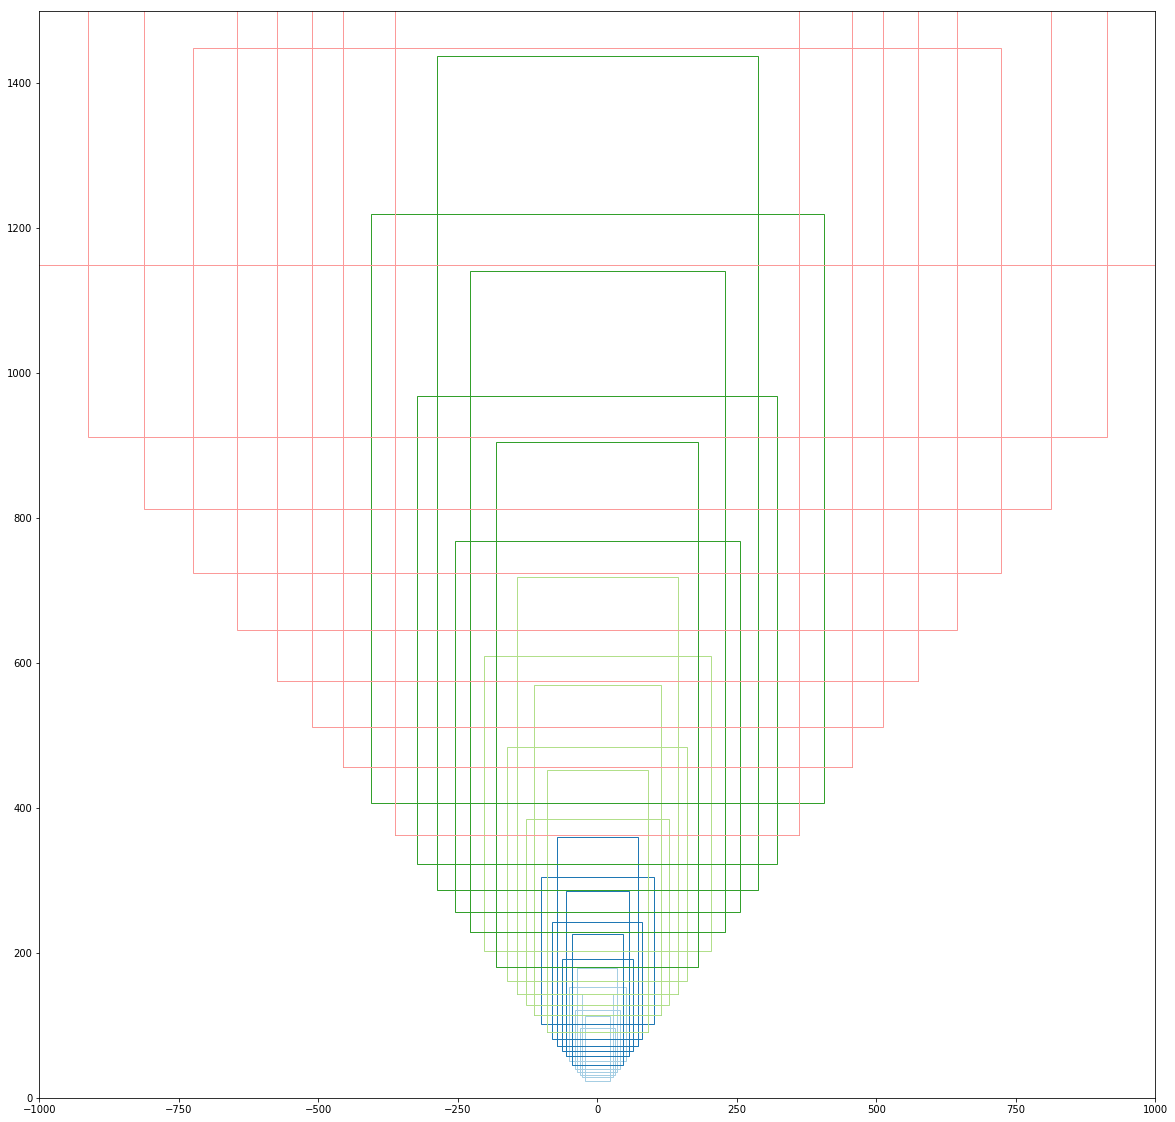

In [218]:
fig, ax = plt.subplots(1, 1, figsize = (20, 20))
plt.xlim(-1000, 1000); plt.ylim(-0, 1500)
for i, s in enumerate(sizes):
    anchs =anchors.generate_anchors(s, ratios, scales)
    for a in anchs:
        x, y, w, h = xy2wh(*a)
        rect = patches.Rectangle((x, y), w, h, facecolor='none', edgecolor=cc[i])
        ax.add_patch(rect)